# Mix Notebook

## Requirements

In [9]:
# Necessary imports for the program
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from eyeInfo import EyeInfo

## Configuration

In [10]:
# set the name prefix in the variable prefix for analysis
prefix = 'e2e_test3'
# number of data points per calibration point
subset_size = 100

# configuration for the program
is_subset = True
lock_plot = False

# display configuration
display_centroid = True
display_train_data = True
display_prediction = True
display_label = True

In [11]:
# Set the name of the csv files
output = './csv/output/output.csv'
output_right = './csv/output/outright.csv'
output_left = './csv/output/outleft.csv'
train_input = f'./csv/data/{prefix}_fixed_train_data.csv'

# Column names for the csv files
fieldnames = ['screen_x', 'screen_y','left_iris_x','left_iris_y','right_iris_x','right_iris_y']
fieldnames_left = ['screen_x', 'screen_y', 'left_iris_x','left_iris_y']
fieldnames_rigth = ['screen_x', 'screen_y', 'right_iris_x','right_iris_y']

# Color palette for the clusters
full_palette = {
    'calib_df': 'black',
    'first': 'blue',
    'second': 'red',
    'third': 'green',
    'fourth': 'yellow',
    'fifth':'lightgreen',
    'sixth': 'purple',
    'seventh': 'orange',
    'eighth': 'pink',
    'ninth': 'turquoise'
}

# Legend for the clusters
full_legend_dict = {
    full_palette['first']: 'Cluster 1',
    full_palette['second']: 'Cluster 2',
    full_palette['third']: 'Cluster 3',
    full_palette['fourth']: 'Cluster 4',
    full_palette['fifth']: 'Cluster 5',
    full_palette['sixth']: 'Cluster 6',
    full_palette['seventh']: 'Cluster 7',
    full_palette['eighth']: 'Cluster 8',
    full_palette['ninth']: 'Cluster 9',
}

## Model Training

In [12]:
def train_to_validate_calib(output, fieldnames, isLeft, isRight, test_size=0.2):
    """
    Train the model to validate calibration and write the predictions to a CSV file.

    Args:
    - output (str): The path to the output CSV file.
    - fieldnames (list): The field names for the CSV file header.
    - isLeft (bool): Flag indicating whether the calibration is for the left eye.
    - isRight (bool): Flag indicating whether the calibration is for the right eye.
    - test_size (float): The proportion of the dataset to include in the test split.

    Returns:
        None
    """

    # Set the path for the csv files
    dataset_train_path = train_input

    # Read the data from the train csv file
    data = pd.read_csv(dataset_train_path)

    # Set the X and y values for the model to train
    if isLeft:
        X = data[["left_iris_x", "left_iris_y"]]
        y = data[["point_x", "point_y"]]
    elif isRight:
        X = data[["right_iris_x", "right_iris_y"]]
        y = data[["point_x", "point_y"]]
    else:
        X = data[["left_iris_x", "left_iris_y", "right_iris_x", "right_iris_y"]]
        y = data[["point_x", "point_y"]]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Train the model
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)
    combined_predictions = np.concatenate((predictions, X_test), axis=1)

    # Write the predictions to the output csv file
    with open(output, mode="w", newline="") as file:
        # Write the header of the csv file
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()

        # Iterate through the predictions and write them to the csv file
        for row in combined_predictions:
            if isLeft:
                writer.writerow(
                    {
                        "screen_x": row[0],
                        "screen_y": row[1],
                        "left_iris_x": row[2],
                        "left_iris_y": row[3],
                    }
                )
            elif isRight:
                writer.writerow(
                    {
                        "screen_x": row[0],
                        "screen_y": row[1],
                        "right_iris_x": row[2],
                        "right_iris_y": row[3],
                    }
                )
            else:
                writer.writerow(
                    {
                        "screen_x": row[0],
                        "screen_y": row[1],
                        "left_iris_x": row[2],
                        "left_iris_y": row[3],
                        "right_iris_x": row[4],
                        "right_iris_y": row[5],
                    }
                )


def extract_calib(csv_path, entries):
    """
    Extracts unique calibration points from a CSV file.

    Args:
        csv_path (str): The path to the CSV file.
        entries (int): The number of unique points to extract.

    Returns:
        list: A list of dictionaries representing the unique points, each containing the 'x' and 'y' coordinates.
    """

    # Read the data from the csv file
    df = pd.read_csv(csv_path)

    # Initialize the unique points list
    unique_points = []
    seen = set()
    change = 0

    # Iterate through the data and extract the unique points
    for index, row in df.iterrows():
        # Extract the point x and y values
        point_x, point_y = row["point_x"], row["point_y"]

        # Check if the point is not seen before
        if (point_x, point_y) not in seen:
            # Increment the change value
            change = change + 1

            # Add the point to the unique points list and seen set
            unique_points.append({"x": point_x, "y": point_y, "order": change})
            seen.add((point_x, point_y))

        # Break if we have enough unique points
        if len(unique_points) == entries:
            break

    # Return the unique points
    return unique_points


def extract_hw(csv_path):
    """
    Extracts the screen height and width from a CSV file.

    Args:
        csv_path (str): The path to the CSV file.

    Returns:
        tuple: A tuple containing the screen height and width.
    """

    # Read the data from the csv file
    df = pd.read_csv(csv_path)
    interest = df.iloc[0]

    # Return the screen height and width
    return interest["screen_height"], interest["screen_width"]

In [13]:
train_to_validate_calib(output, fieldnames, isLeft=False, isRight=False)

In [14]:
# Extract the calibration points and screen height and width
calib_points = extract_calib(train_input, subset_size)
h, w = extract_hw(train_input)

# Legend dictionary
legend_dict = {
    key: full_legend_dict[key] for key in list(full_legend_dict)[: len(calib_points)]
}

# Initialize the EyeInfo object
eye = EyeInfo(
    calib_points=calib_points, dataset=output, screen_height=h, screen_width=w
)
eye.init_eye()

## Visualizations

In [15]:
def full_plot(df, eyes_only):
    """
    Plots the eye data from the given dataframe.

    Args:
        df (pandas.DataFrame): The dataframe containing the eye data.
        eyes_only (bool): If True, only plots the eye data. If False, plots both eye and centroid data.

    Returns:
        None
    """

    # Create the subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Both Eyes plot
    axs[0].set_title("Both Eyes - Fixed Train")
    eye.plot(
        datasets=[df, df],
        keys_x=["left_iris_x", "right_iris_x"],
        keys_y=["left_iris_y", "right_iris_y"],
        is_subset=is_subset,
        subset_size=subset_size,
        lock_plot=lock_plot,
        eyes_only=eyes_only,
        ax=axs[0],
        display_centroid=display_centroid,
    )

    # Left Eyes plot
    axs[1].set_title("Left Eyes - Fixed Train")
    eye.plot(
        datasets=[df],
        keys_x=["left_iris_x"],
        keys_y=["left_iris_y"],
        is_subset=is_subset,
        subset_size=subset_size,
        lock_plot=lock_plot,
        eyes_only=display_train_data,
        ax=axs[1],
        display_centroid=display_centroid,
    )

    # Right Eye plot
    axs[2].set_title("Right Eye - Fixed Train")
    eye.plot(
        datasets=[df],
        keys_x=["right_iris_x"],
        keys_y=["right_iris_y"],
        is_subset=is_subset,
        subset_size=subset_size,
        lock_plot=lock_plot,
        eyes_only=display_train_data,
        ax=axs[2],
        display_centroid=display_centroid,
    )
    
    if display_label:
        for color, label in legend_dict.items():
            plt.scatter([], [], c=color, label=label)
            plt.legend(bbox_to_anchor=(1, 1))

    # Display the plot
    plt.tight_layout()
    plt.show()

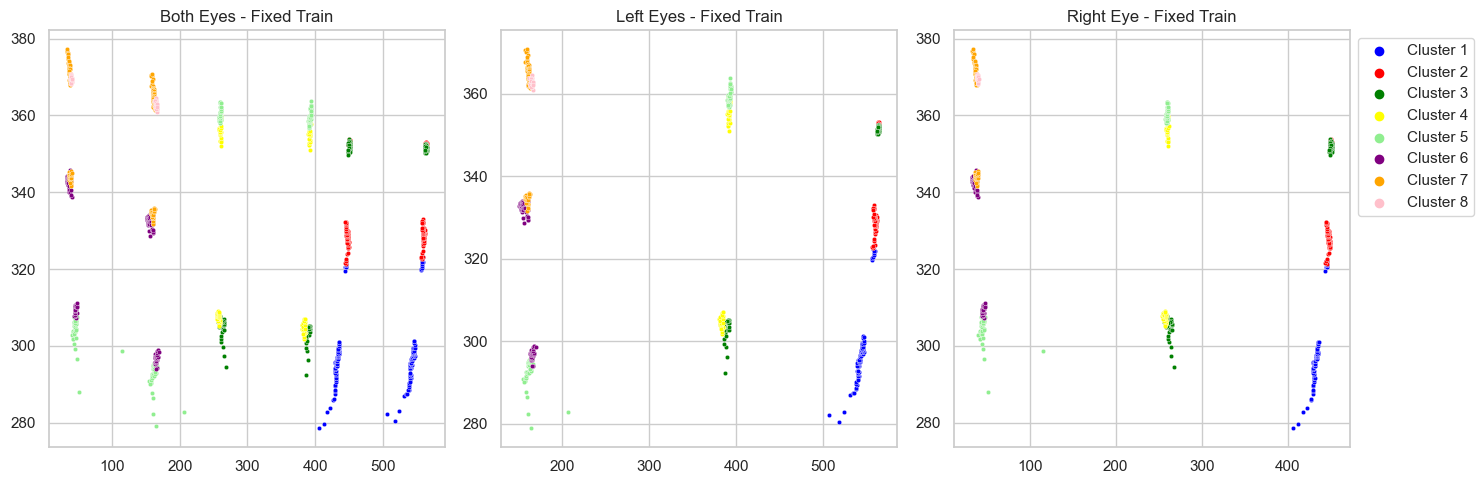

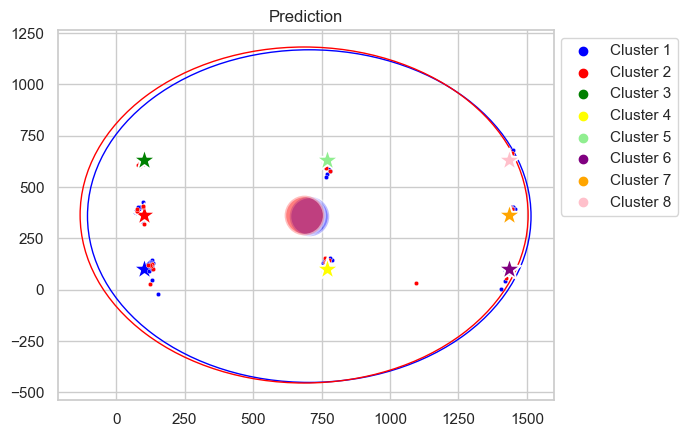

In [16]:
# Prediction data
prediction_df = eye.prediction_df

# Read the train data from the csv file
fixed_train_df = pd.read_csv(train_input)

# Display the plots based on the configuration
if display_train_data:
    full_plot(fixed_train_df, True)

if display_prediction:
    # Display the prediction plot
    fig, ax = plt.subplots(1, 1)
    eye.plot(
        datasets=[prediction_df],
        keys_x=["screen_x"],
        keys_y=["screen_y"],
        is_subset=is_subset,
        subset_size=subset_size,
        lock_plot=lock_plot,
        eyes_only=not display_prediction,
        ax=ax,
        display_centroid=display_centroid,
    )

    # Set the title of the plot
    ax.set_title("Prediction")

    if display_label:
        for color, label in legend_dict.items():
            plt.scatter([], [], c=color, label=label)
            plt.legend(bbox_to_anchor=(1, 1))

    # Display the plot
    plt.show()